# Capítulo 9 – Detección de Anomalías con LSTM Autoencoders

En este capítulo se aborda el enfoque de **LSTM Autoencoders**, una extensión natural de los autoencoders clásicos que incorpora **memoria temporal** a través de redes recurrentes.  

A diferencia del autoencoder estándar, que procesa los datos como vectores independientes, el **LSTM Autoencoder** aprende a modelar secuencias completas, capturando dependencias a corto y largo plazo.  
Esto lo convierte en una herramienta idónea para la detección de anomalías en **series temporales**, donde el contexto de varias observaciones sucesivas resulta determinante.

## Motivación

El uso de LSTM Autoencoders se justifica por varias razones:

- Capturan **patrones dinámicos y secuenciales** en los datos.  
- Permiten identificar anomalías que no se manifiestan en un único instante, sino en un **conjunto de pasos consecutivos**.  
- Se adaptan mejor a datos multivariantes con **dependencias temporales complejas**.  
- Amplían el marco de los autoencoders tradicionales hacia arquitecturas específicamente diseñadas para series temporales.  

## Objetivo del capítulo

Este capítulo abordará:

- Los fundamentos teóricos de los LSTM Autoencoders y su aplicación en detección de anomalías.  
- La implementación de un modelo entrenado sobre datos sintéticos y su validación mediante walk-forward incremental.  
- El análisis del error de reconstrucción como score de anomalía en un contexto secuencial.  
- La comparación con el autoencoder clásico y los modelos clásicos estudiados previamente.  

## Intuición

El LSTM Autoencoder está formado por dos bloques:

- **Encoder LSTM**: procesa la secuencia de entrada y la resume en un estado latente que captura dependencias temporales.  
- **Decoder LSTM**: a partir del estado latente, reconstruye la secuencia original paso a paso.  

De forma intuitiva:

> Un LSTM Autoencoder aprende a reproducir secuencias normales.  
> Cuando recibe una secuencia anómala, la reconstrucción falla en varios pasos consecutivos, lo que genera un error de reconstrucción elevado y permite identificar la anomalía.

## Fundamento teórico

El entrenamiento del LSTM Autoencoder se plantea como la minimización del error de reconstrucción secuencial:

$$
\min_{\theta} \sum_{t=1}^T L(x_t, \hat{x}_t)
$$

donde:

- $x_t$: valor real en el instante $t$.  
- $\hat{x}_t$: valor reconstruido por el decoder en el instante $t$.  
- $L(\cdot)$: función de pérdida, típicamente el MSE.  

El score de anomalía para una secuencia $X = (x_1, \dots, x_T)$ se define como:

$$
s(X) = \frac{1}{T} \sum_{t=1}^T \|x_t - \hat{x}_t\|^2
$$

Si $s(X)$ supera un umbral, la secuencia se clasifica como anómala.

## Parámetros clave

- Longitud de la ventana temporal.  
- Dimensión del espacio latente.  
- Número de capas y unidades LSTM en encoder y decoder.  
- Función de pérdida (MSE, MAE, etc.).  
- Estrategias de regularización (dropout, gradient clipping).  

## Ventajas

- Capturan dependencias a corto y largo plazo.  
- Adecuados para anomalías que afectan a patrones secuenciales completos.  
- Extienden el poder representativo de los autoencoders clásicos a datos temporales.  

## Limitaciones

- Mayor complejidad computacional y tiempo de entrenamiento.  
- Requieren un ajuste cuidadoso de la longitud de ventana y la arquitectura.  
- Riesgo de sobreajuste si no se aplican técnicas de regularización adecuadas.  

## Ejemplo

Consideremos la monitorización de una **turbina eólica** mediante múltiples sensores de vibración y presión.  

En condiciones normales, las señales siguen patrones recurrentes estables.  
Si se produce una anomalía progresiva, como un **desbalance en el rotor**, el LSTM Autoencoder —entrenado para reproducir secuencias normales— no podrá reconstruir correctamente la evolución temporal de las señales.  

El error de reconstrucción se incrementará en varios pasos consecutivos, señalando la presencia de la anomalía.


## Validación experimental de LSTM Autoencoder

En este apartado se describe el procedimiento de validación aplicado al modelo **LSTM Autoencoder** para la detección de anomalías en series temporales. El objetivo es evaluar la capacidad del modelo para capturar dependencias temporales y compararlo con los enfoques previamente estudiados.

El protocolo seguido consta de los siguientes pasos:

1. **Generación y partición de datos**: se emplea un conjunto sintético de series temporales con anomalías inyectadas, dividido en subconjuntos de entrenamiento (*train*), validación (*val*) y prueba (*test*). Los conjuntos *train* y *val* se combinan para la búsqueda de hiperparámetros, reservando *test* exclusivamente para la evaluación final.

2. **Esquema de validación walkforward**: se utiliza un procedimiento de validación **walkforward** para reflejar el carácter incremental del entrenamiento. En cada iteración, el modelo se reentrena con todos los datos disponibles hasta el momento y se valida en el bloque temporal siguiente, garantizando que no exista fuga de información futura.

3. **Preprocesado de datos**: sobre cada bloque se aplica el mismo pipeline utilizado en modelos anteriores, consistente en:
   - Aplicación del filtro de Hampel sobre los residuos estacionales.
   - Estimación automática de la periodicidad estacional cuando corresponde.
   - Normalización de los datos mediante *StandardScaler*, asegurando la estabilidad del entrenamiento.

4. **Construcción de secuencias**: los datos se estructuran en ventanas temporales de longitud fija (`seq_len`). Cada ventana se considera una muestra de entrada para el LSTM Autoencoder, que debe reconstruirla paso a paso.

5. **Búsqueda de hiperparámetros**: se exploran diferentes configuraciones de:
   - Número de capas y unidades ocultas del LSTM (`num_layers`, `hidden_size`).
   - Longitud de secuencia (`seq_len`).
   - Tasa de aprendizaje (`lr`).
   - Número de épocas de entrenamiento por bloque (`epochs`).
   - Tamaño de lote (`batch_size`).

6. **Métricas de validación**: en cada iteración del esquema walkforward se calculan las métricas **precision**, **recall**, **F1**, **ROC-AUC**, **NAB** y **window coverage**. Posteriormente, se seleccionan las cinco mejores configuraciones atendiendo al valor medio de NAB.

7. **Evaluación final en test**: las configuraciones seleccionadas se reentrenan sobre *train+val* y se evalúan en *test*, generando tanto curvas ROC como representaciones gráficas de anomalías reales frente a anomalías detectadas.

Este procedimiento permite analizar el comportamiento del LSTM Autoencoder en escenarios dinámicos, valorando su capacidad de modelar la estructura temporal y comparando su rendimiento con los modelos previos.


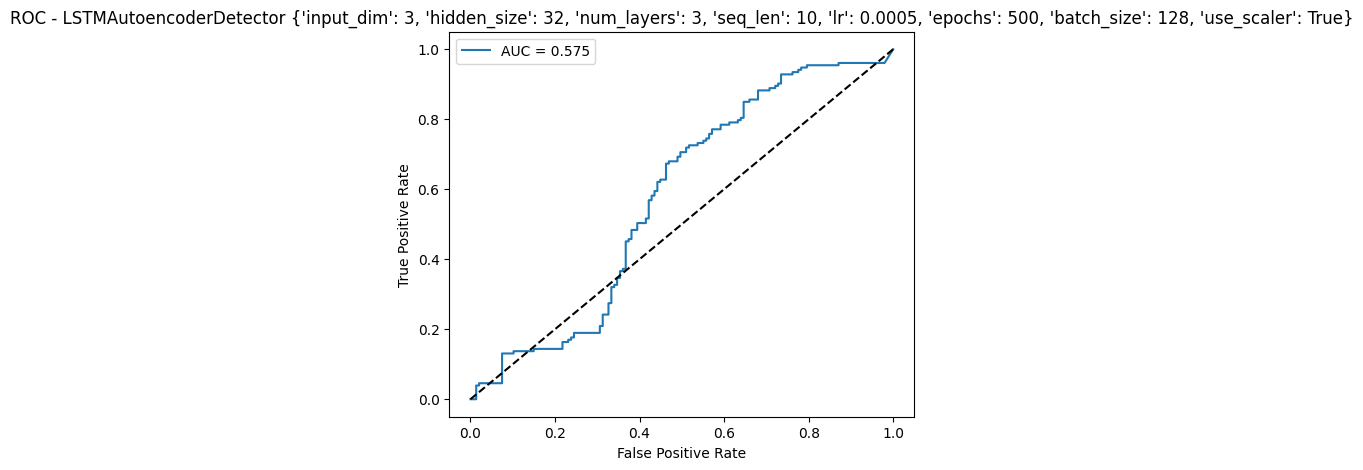

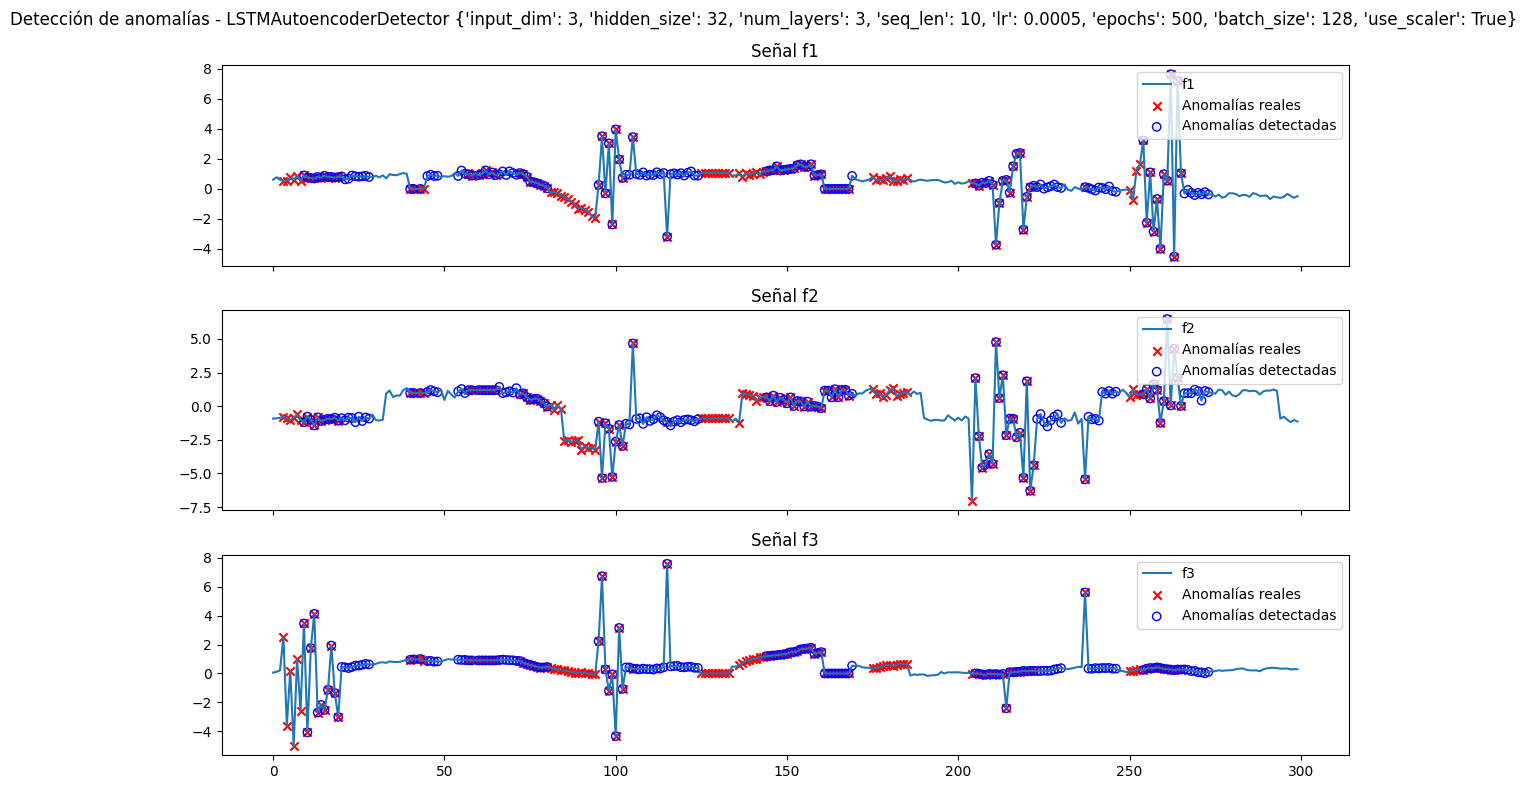

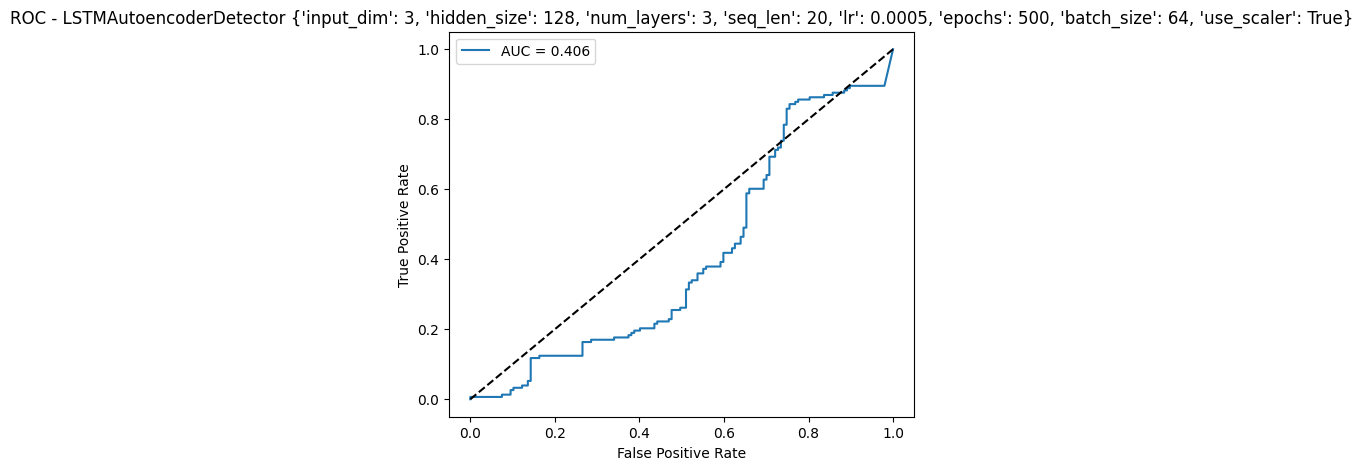

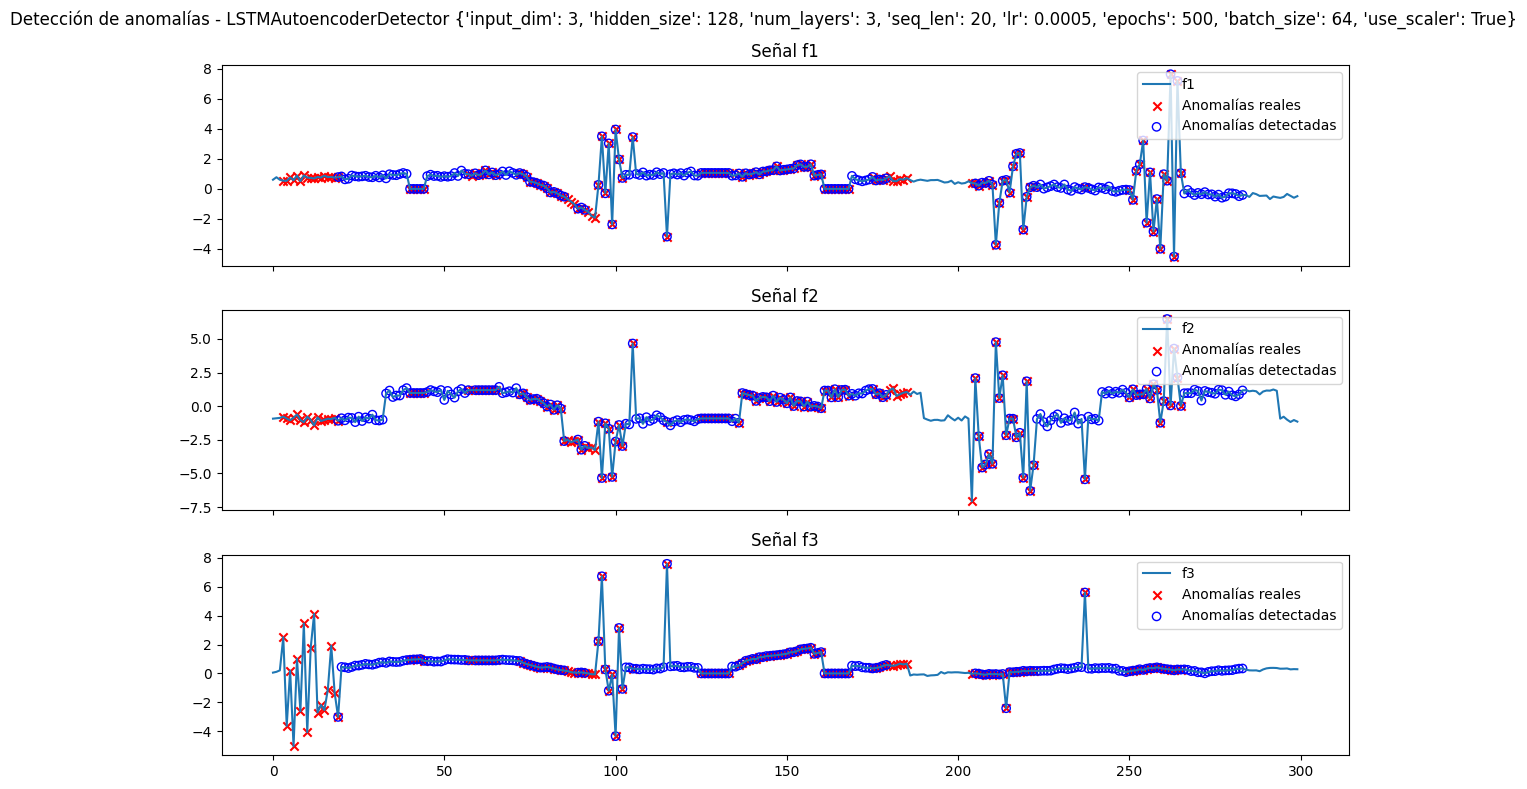

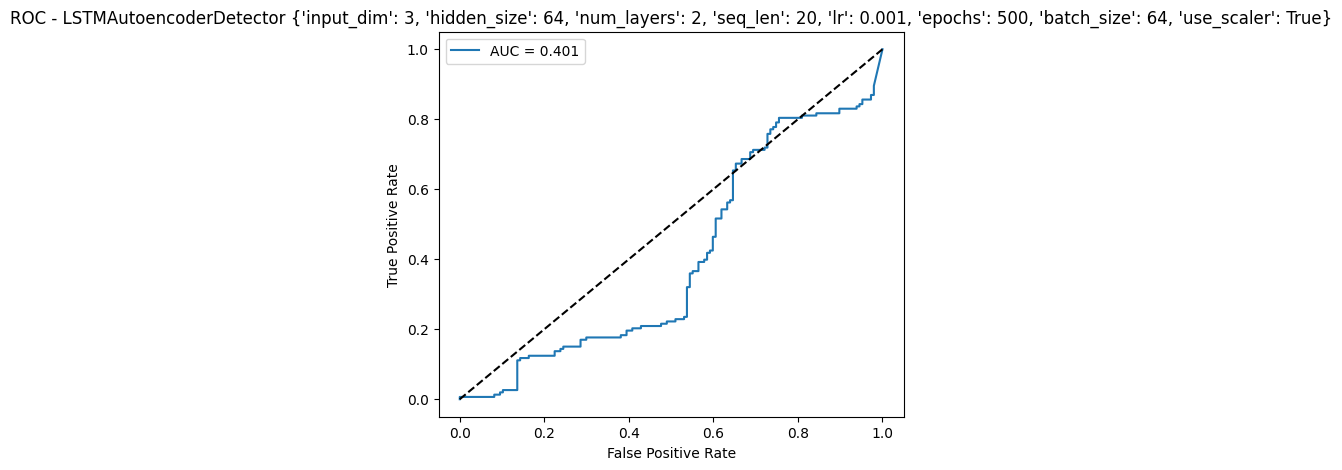

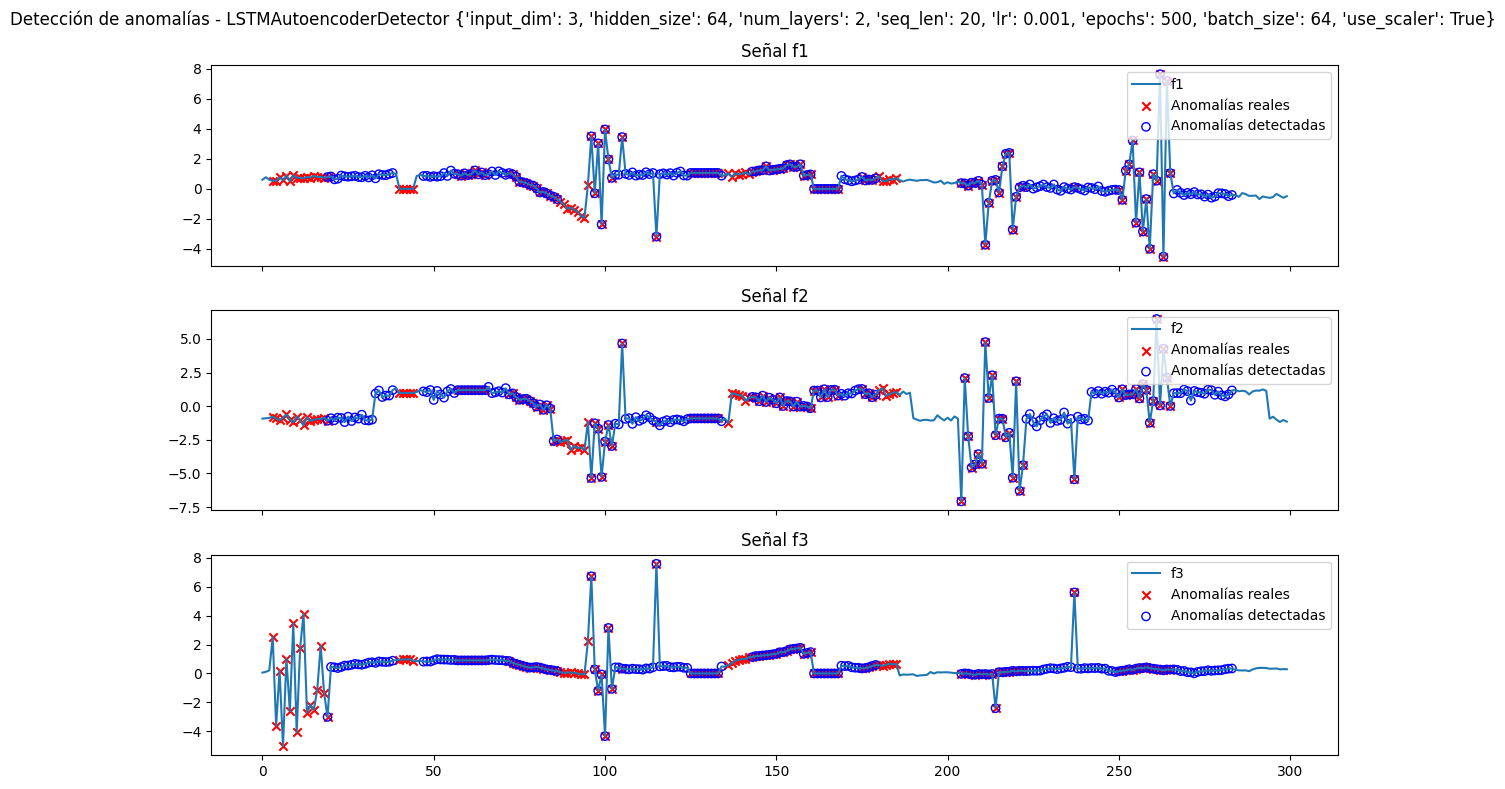

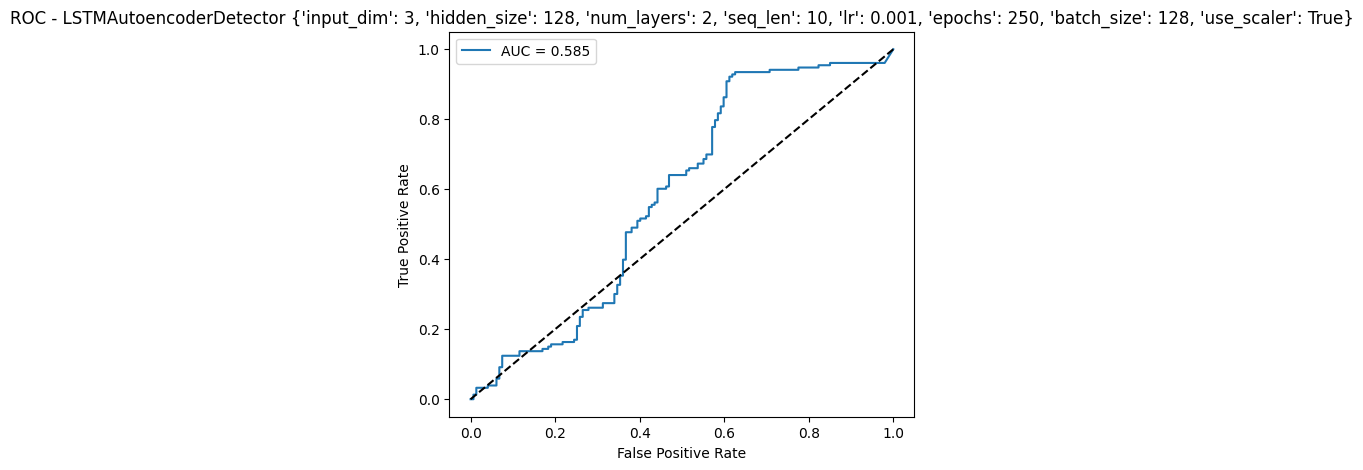

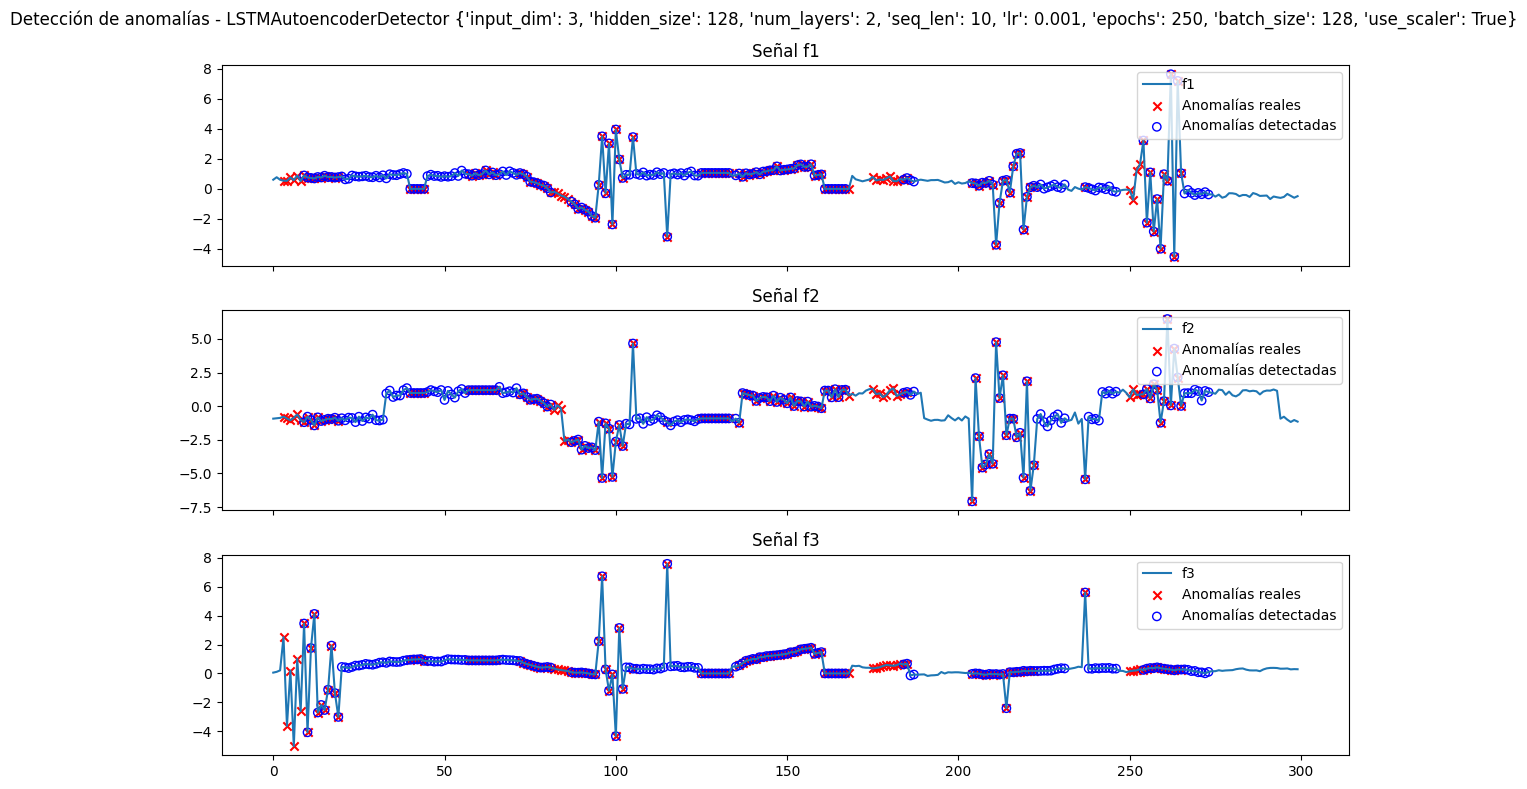

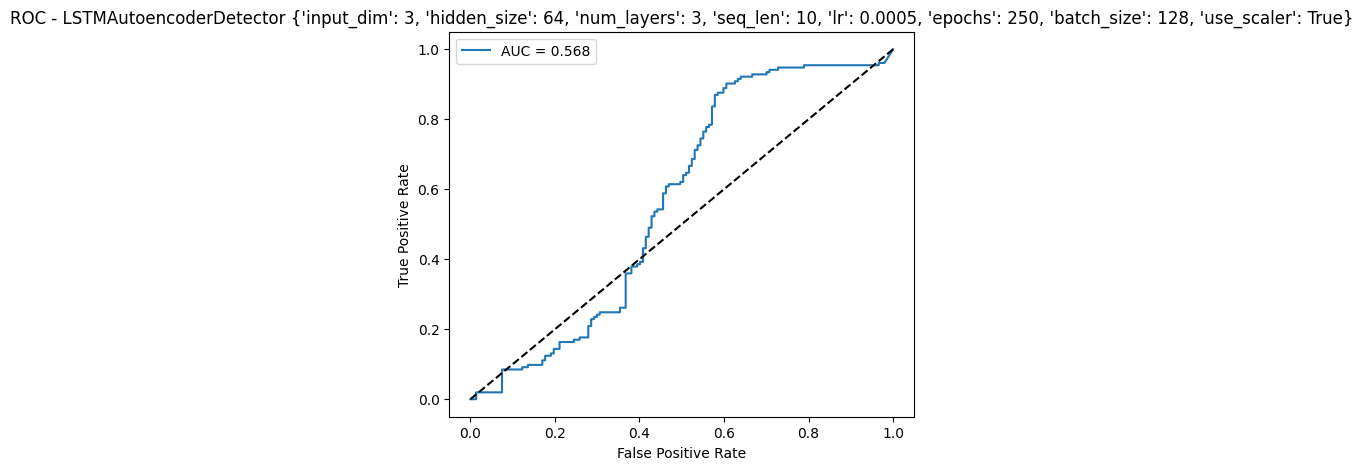

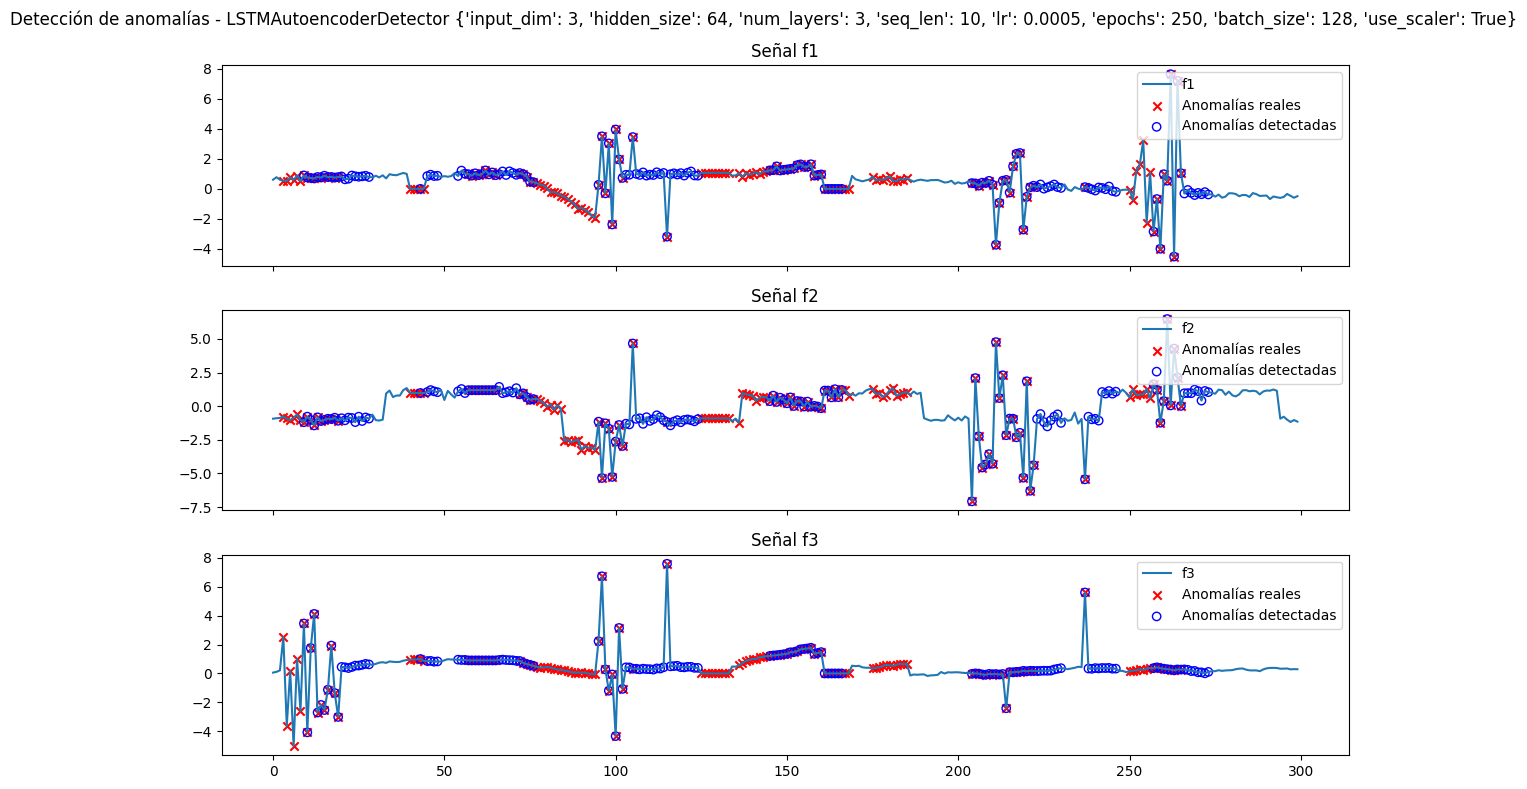

Resultados de validación (grid search en train+val):


,precision,recall,f1,roc_auc,nab,window_cov,input_dim,hidden_size,num_layers,seq_len,lr,epochs,batch_size,use_scaler
0,0.494,0.682,0.554,0.699,0.617,0.586,3,32,2,10,0.001,50,64,True
1,0.438,0.707,0.499,0.733,0.637,0.650,3,32,2,10,0.001,50,128,True
2,0.413,0.692,0.486,0.753,0.571,0.593,3,32,2,10,0.001,100,64,True
3,0.416,0.706,0.494,0.718,0.626,0.614,3,32,2,10,0.001,100,128,True
4,0.440,0.669,0.492,0.737,0.538,0.574,3,32,2,10,0.000,50,64,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.424,0.696,0.494,0.693,0.611,0.665,3,128,3,20,0.001,100,128,True
92,0.424,0.665,0.491,0.681,0.561,0.565,3,128,3,20,0.000,50,64,True
93,0.444,0.642,0.508,0.667,0.564,0.541,3,128,3,20,0.000,50,128,True
94,0.437,0.676,0.508,0.703,0.665,0.608,3,128,3,20,0.000,100,64,True


Top 5 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_cov,input_dim,hidden_size,num_layers,seq_len,lr,epochs,batch_size,use_scaler
23,0.497,0.702,0.562,0.761,0.714,0.636,3,32,3,10,0.000,100,128,True
94,0.437,0.676,0.508,0.703,0.665,0.608,3,128,3,20,0.000,100,64,True
42,0.437,0.684,0.515,0.688,0.654,0.594,3,64,2,20,0.001,100,64,True
65,0.440,0.702,0.498,0.745,0.648,0.643,3,128,2,10,0.001,50,128,True
53,0.501,0.678,0.555,0.741,0.647,0.579,3,64,3,10,0.000,50,128,True


Resultados finales en TEST (top-5 configs):


,precision,recall,f1,roc_auc,nab,window_cov,input_dim,hidden_size,num_layers,seq_len,lr,epochs,batch_size,use_scaler
0,0.588,0.634,0.610,0.575,0.843,0.678,3,32,3,10,0.000,500,128,True
1,0.528,0.804,0.637,0.406,0.831,0.846,3,128,3,20,0.000,500,64,True
2,0.509,0.719,0.596,0.401,0.832,0.751,3,64,2,20,0.001,500,64,True
3,0.595,0.837,0.696,0.585,0.876,0.866,3,128,2,10,0.001,250,128,True
4,0.565,0.569,0.567,0.568,0.838,0.625,3,64,3,10,0.000,250,128,True


In [1]:
# ==========================
# 0. Imports
# ==========================
import pandas as pd
from utils import generate_synthetic_timeseries
from modelos.LSTMAutoencoderDetector import LSTMAutoencoderDetector
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)
from runner import run_experiment

# ==========================
# 1. Generar datos sintéticos
# ==========================
df_train, df_val, df_test = generate_synthetic_timeseries(
    n=1000, train_ratio=0.4, val_ratio=0.3, anomaly_ratio=0.06, seed=42
)

df_trainval = pd.concat([df_train, df_val], ignore_index=True)
X_trainval, y_trainval = df_trainval[["f1", "f2", "f3"]], df_trainval["anomaly"]
X_test, y_test = df_test[["f1", "f2", "f3"]], df_test["anomaly"]

# ==========================
# 2. Definir métricas
# ==========================
metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_cov": window_coverage_metric
}

# ==========================
# 3. Definir grid de hiperparámetros
# ==========================
param_grid_lstm_ae = {
    "input_dim": [3],                   # número de características en los datos de entrada
    "hidden_size": [32, 64, 128],       # tamaño de la capa oculta LSTM
    "num_layers": [2, 3],               # número de capas LSTM
    "seq_len": [10, 20],                # longitud de la secuencia de entrada
    "lr": [1e-3, 5e-4],                 # tasa de aprendizaje
    "epochs": [50, 100],                 # número de épocas de entrenamiento
    "batch_size": [64, 128],            # tamaño del batch
    "use_scaler": [True]                # si se debe escalar los datos
}



# ==========================
# 4. Ejecutar experimento con walkforward
# ==========================
df_results, top5, df_final = run_experiment(
    model_class=LSTMAutoencoderDetector,
    param_grid=param_grid_lstm_ae,
    X_trainval=X_trainval,
    y_trainval=y_trainval,
    X_test=X_test,
    y_test=y_test,
    metrics=metrics,
    params_cv={"P_train": 0.4, "num_windows": 5},
    mode="walkforward",                           
    sort_metric="nab",
    top_k=5,
    plot_results=True,
    df_test=df_test
)



### Referencias

[1] Malhotra, P., Ramakrishnan, A., Anand, G., Vig, L., Agarwal, P., & Shroff, G. (2016).  
**LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection.**  
*arXiv preprint* arXiv:1607.00148. https://arxiv.org/pdf/1607.00148.pdf  

[2] Malhotra, P., TV, V., Vig, L., Agarwal, P., & Shroff, G. (2015).  
**Long Short Term Memory Networks for Anomaly Detection in Time Series.**  
*Proceedings, ESANN 2015.* https://arxiv.org/abs/1507.05292  

[3] Tuli, S., Casale, G., & Jennings, N. R. (2022).  
**TranAD: Deep Transformer Networks for Anomaly Detection in Multivariate Time Series Data.**  
*Proceedings of VLDB 2022.* https://github.com/imperial-qore/TranAD  


Eperimento potente

In [1]:
import warnings
warnings.filterwarnings("ignore", message="Cannot get CPU affinity")

from dask_cuda import LocalCUDACluster
from dask.distributed import Client, LocalCluster

# ⚡ Cluster: CPU o GPU según necesites
# cluster = LocalCluster()   # CPU
cluster = LocalCUDACluster()  # GPU distribuida (si tienes varias)
client = Client(cluster)

# Dashboard en http://127.0.0.1:8787

# ===================================================
# Experimento con Transformer Autoencoder
# ===================================================
from runner import run_dataset_experiment

from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)

metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_coverage": window_coverage_metric,
}

# --- Hiperparámetros del Transformer Autoencoder ---
param_grid = {          
    "seq_len": [10],      # longitudes de ventana a probar
    "lr": [1e-4, 5e-4, 1e-3, 5e-3],
    "epochs": [20, 50],
    "batch_size": [256, 512],
}

from modelos.TransformerAutoencoderDetector import TransformerAutoencoderDetector

df_results, topk, df_final = run_dataset_experiment(
    dataset_name="BATADAL",          # cámbialo por tu dataset
    model_class=TransformerAutoencoderDetector,
    param_grid=param_grid,
    metrics=metrics,
    params_cv={"num_windows": 3},    # nº de splits de validación
    device="gpu",                    # "cpu" o "gpu"
    mode="walkforward",              # validación expansiva
    hampel_cfg={"window": 100, "sigma": 5.0},
    top_k=5,
    sort_metric="nab",
    plot_mode="best"
)


<Client: 'tcp://127.0.0.1:45073' processes=1 threads=1, memory=49.02 GiB>
🏁 Ejecutando experimento en dataset: BATADAL
[✓] DATA cargado desde /home/pablo/TFG/MDF-ANOMALY-DETECTION/modelos/data/BATADAL/data.parquet (12938 filas)
   - Train: 8761 filas
   - Val:   2506 filas
   - Test:  1671 filas
Usando GPU (cuDF + CuPy) para este experimento.


Evaluación en test:  20%|██        | 1/5 [00:39<02:36, 39.10s/it]


ValueError: Found input variables with inconsistent numbers of samples: [1653, 1662]